In [1]:
import os

new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/dft_fd_1e-2'
os.chdir(new_path)

In [8]:
from scipy.interpolate import interp1d


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from edpyt.nano_dmft import Gfloc

/users/ajayaraj/miniconda3/envs/qtpyt/lib/python3.9/site-packages/numba/cpython/hashing.py:524: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


In [21]:
nbaths = 4
# U = 4
tol = 1e-4
max_iter = 1000
alpha = 0.0
nspin = 1
de = 0.01
energies = np.arange(-3, 3 + de / 2.0, de).round(7)
eta = 1e-3
z_ret = energies + 1.0j * eta
betas = [2000.0,2500.0]
mu = 0.0
adjust_mu = True
use_double_counting = True

In [22]:
data_folder = "output/lowdin/beta_100"
output_folder = f"output/lowdin/beta_100/U_matrix"
occupancy_goal = np.load(f"{data_folder}/occupancies_gfp_mu_0.0.npy")


In [23]:
H_active = np.load(f"{data_folder}/bare_hamiltonian.npy").real
z_mats = np.load(f"{data_folder}/matsubara_energies.npy")
index_active_region = np.load(f"{data_folder}/index_active_region.npy")

In [35]:
len_active = occupancy_goal.size
hyb_mats = np.fromfile(f"{data_folder}/matsubara_hybridization.bin", complex).reshape(
    z_mats.size,
    len_active,
    len_active,
)
_HybMats = interp1d(z_mats.imag, hyb_mats, axis=0, bounds_error=False, fill_value=0.0)
HybMats = lambda z: _HybMats(z.imag)

hyb_ret = np.fromfile(f"{data_folder}/hybridization.bin", complex).reshape(
    z_ret.size,
    len_active,
    len_active,
)
_HybRet = interp1d(z_ret.real, hyb_ret, axis=0, bounds_error=False, fill_value=0.0)
HybRet = lambda z: _HybRet(z.real)

S_active = np.eye(len_active)
idx_neq = np.arange(len_active)
idx_inv = np.arange(len_active)

In [36]:
def plot(gf, ax=None, eta=1e-5, semilogy=True):
    """Plot the Green's function."""
    if ax is None:
        fig, ax = plt.subplots()
    if semilogy:
        show = getattr(ax, 'semilogy')
    else:
        show = getattr(ax, 'plot')
    w = z_ret.real
    dos = -1/np.pi * gf(z_ret.real+1.j*eta).sum(0).imag
    if dos.ndim>1:
        show(w, dos[0], label=r'spin $\uparrow$')
        show(w, dos[1], label=r'spin $\downarrow$')
    else:
        show(w, dos, label=r'spin $\uparrow$ & $\downarrow$')
    ax.set_xlim(w.min(), w.max())
    ax.set_xlabel('E-E$_F$ [eV]')
    ax.set_ylabel('DOS [a.u.]')
    ax.legend()
    return ax

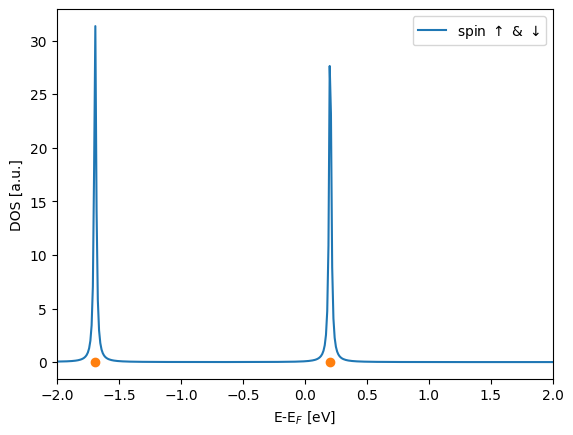

In [38]:
gfloc0 = Gfloc(H_active,S_active, HybMats, idx_neq,idx_inv,z_mats.size,beta)
# gfloc0 = Gfloc(H_active,S_active, HybRet, idx_neq,idx_inv)
gfloc0.set_local(lambda z: np.zeros((len_active,z.size), complex))
gfloc0.update(mu=0.)
eigvals = np.linalg.eigvalsh(H_active)
ax = plot(gfloc0, eta=eta, semilogy=False)
ax.plot(eigvals, np.zeros_like(eigvals), 'o', label='eigenvalues')